In [1]:
import torch
import matplotlib.pyplot as plt
import copy
from score_models import VE, VP
from dataclasses import dataclass
from torch import distributions

import numpy as np
import torch.nn as nn
from scipy.stats import norm

from torch import Tensor
from scipy.spatial import Voronoi, voronoi_plot_2d

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'font.size': 18,
})

# Set parameters
device = torch.device('cpu')

# set seed
torch.manual_seed(0)
np.random.seed(1)

## Define Data

<Figure size 200x200 with 0 Axes>

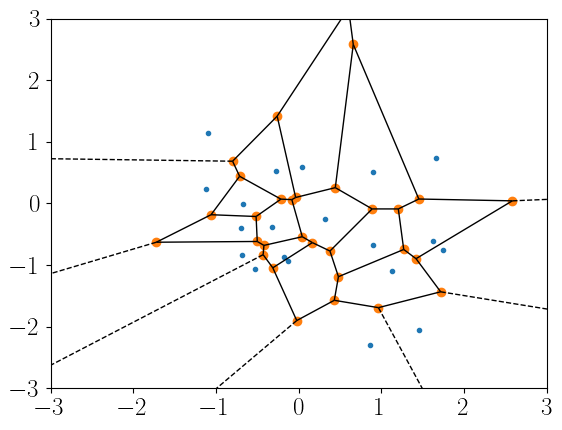

In [2]:
# load data from file
data = np.load('training_data.npy')
N, dim = data.shape

# define voronoi tesselation
vor = Voronoi(data)

# plot
plt.figure(figsize=(2,2))
fig = voronoi_plot_2d(vor)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

## Define models

In [3]:
from score_models import VE, GMM_score_EmpiricalBayes
model = VE()
model.eps = 0.

# define GMM
gmm_train = GMM_score_EmpiricalBayes(torch.tensor(data, dtype=torch.float32), \
    model.marginal_prob_mean, model.marginal_prob_std, tau_constant=0.1)

# test network
dim = data.shape[1]
rand_x = torch.randn(1000, dim).to(device)
rand_t = torch.rand(1,) * torch.ones((1000,1))
print(gmm_train(rand_x, rand_t[:,0]).shape)

torch.Size([1000, 2])


## Generate trajectories

In [4]:
# define latent samples
batch_size = 30
latents = torch.randn(batch_size, dim).to(device)

# evaluate ODE and SDE paths
model.eps = 1e-6
GMM_t, GMM_x = model.ODEsampler(gmm_train, latents)

# evaluate the ODE weights
GMMweights = torch.zeros((len(GMM_t), batch_size, gmm_train.train_data.shape[0]))
for (j,tj) in enumerate(GMM_t):
    batch_time = torch.ones(batch_size, device=latents.device) * tj
    GMMweights[j,:,:] = gmm_train.pdf_weights(GMM_x[:,:,j], batch_time)

### Plot trajectories and weights

/opt/anaconda3/envs/ML/lib/python3.8/site-packages/scipy/spatial/_plotutils.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


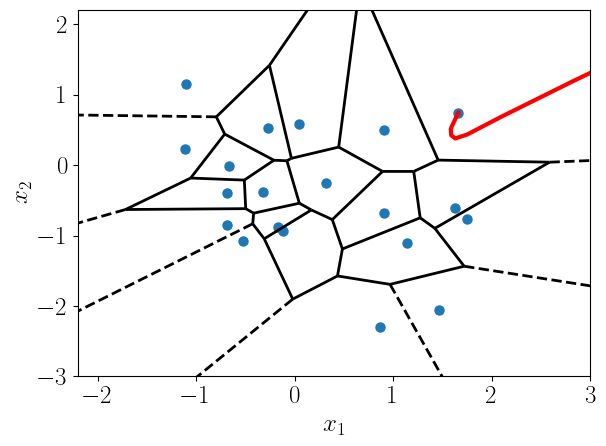

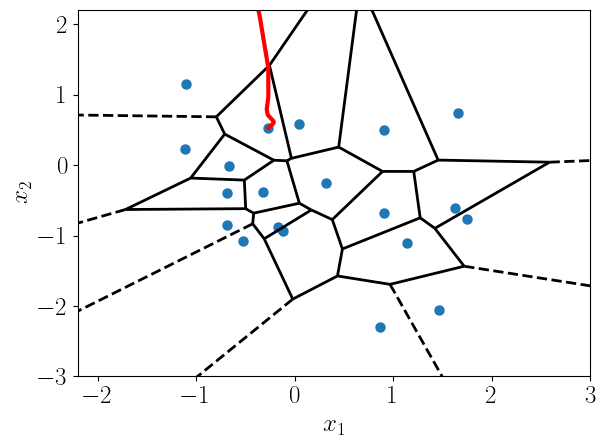

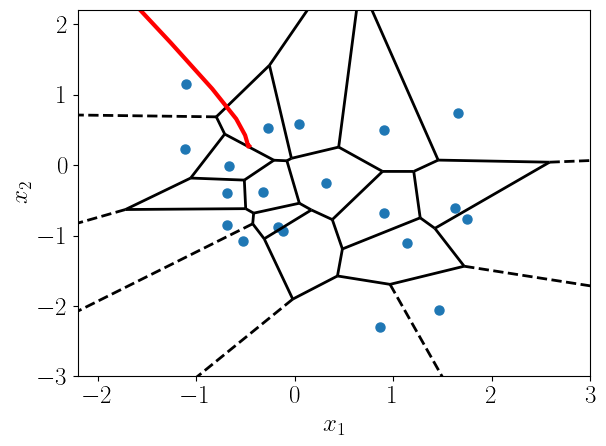

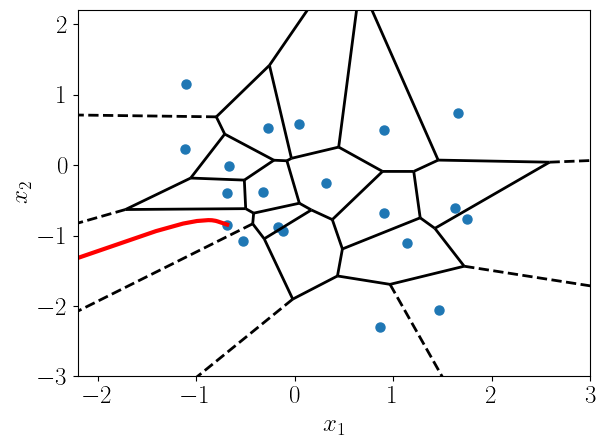

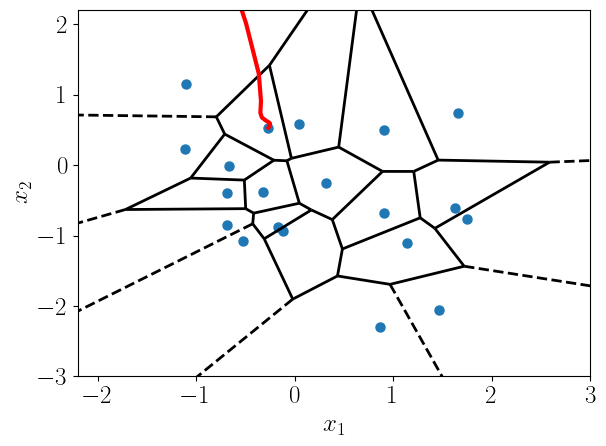

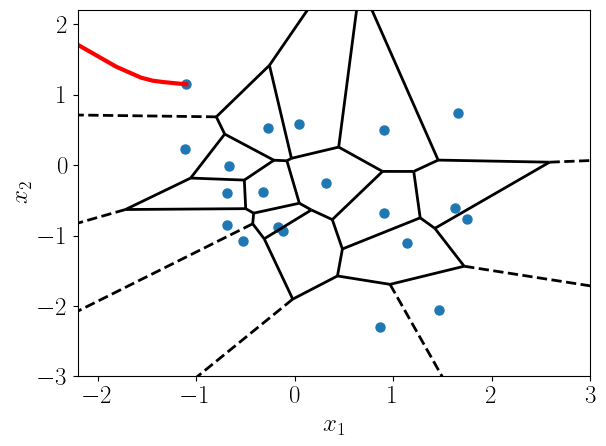

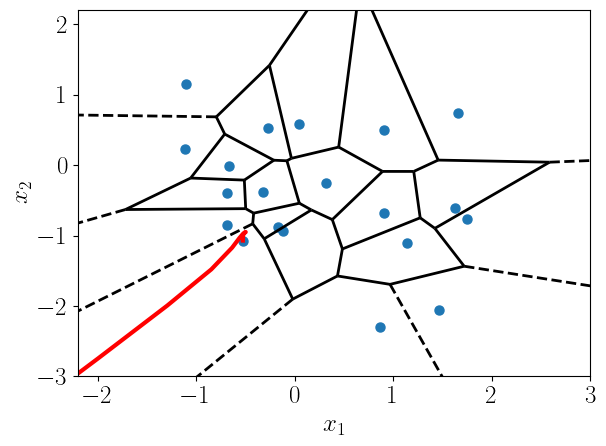

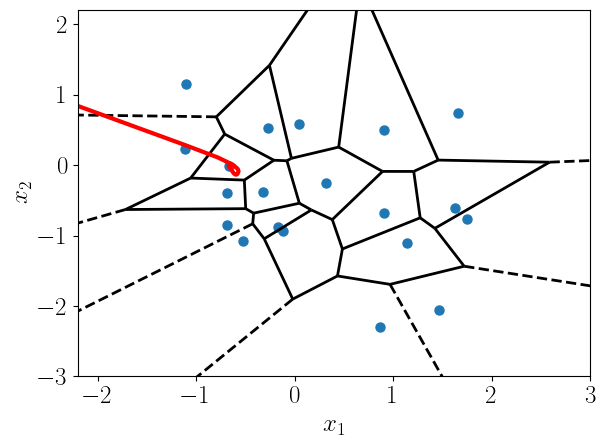

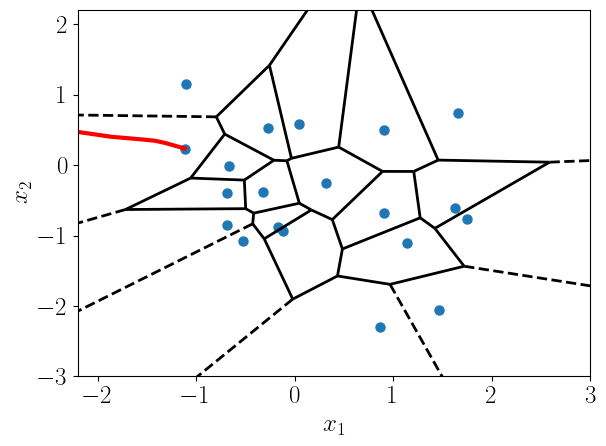

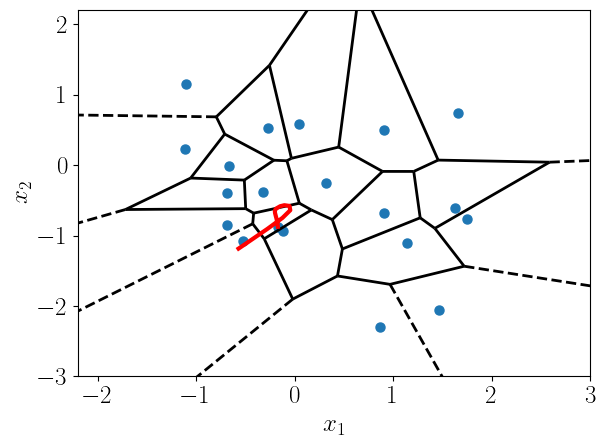

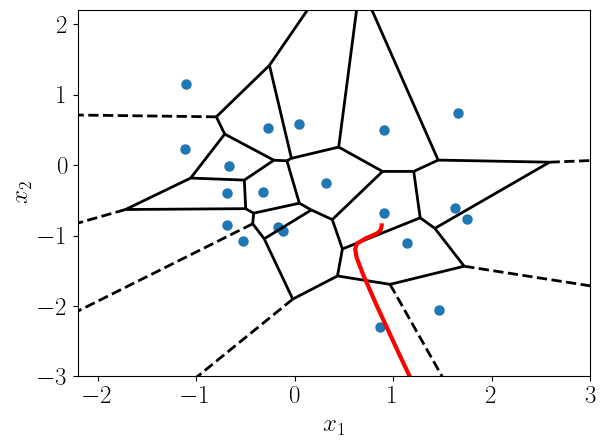

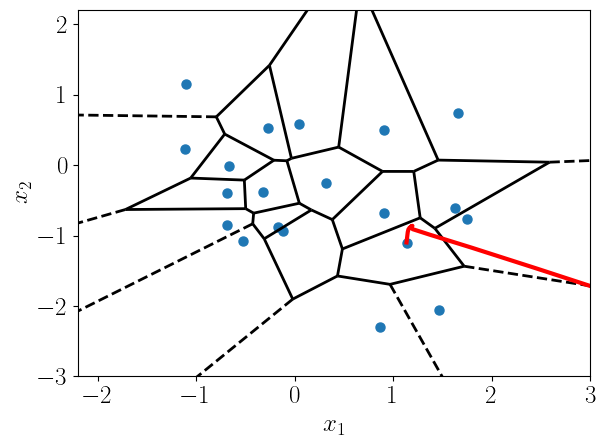

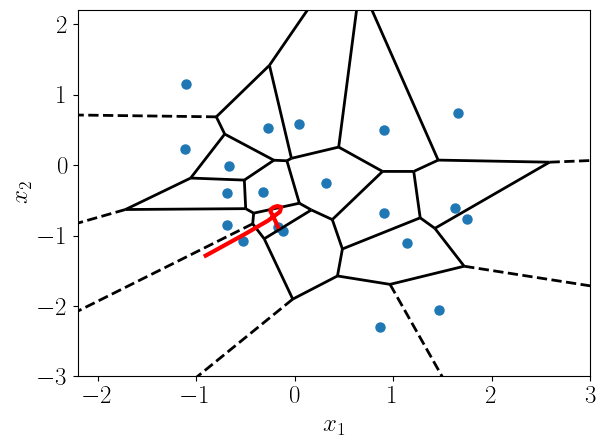

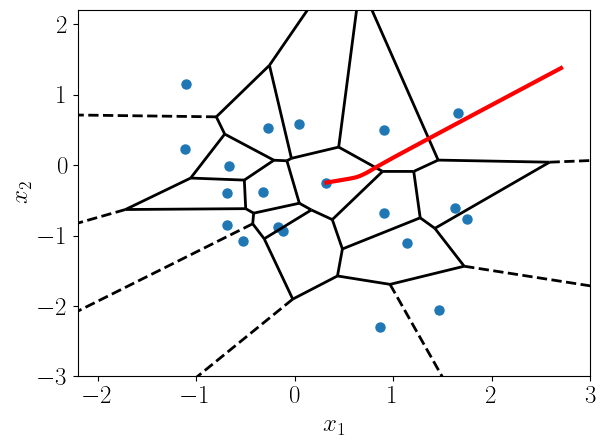

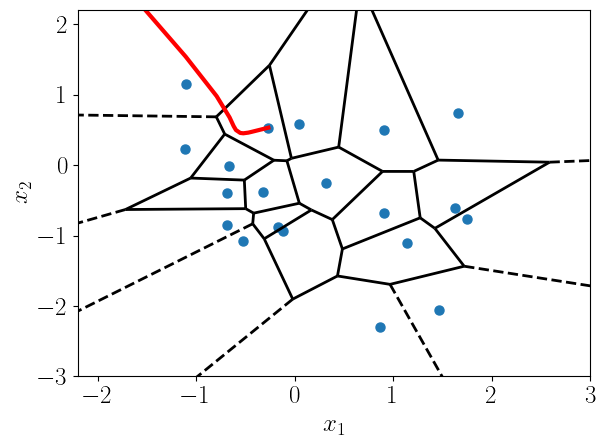

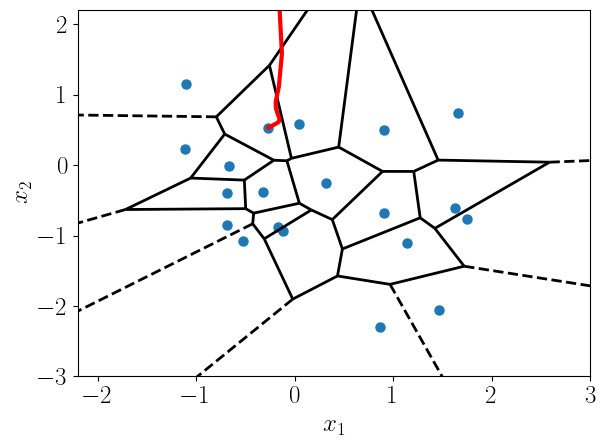

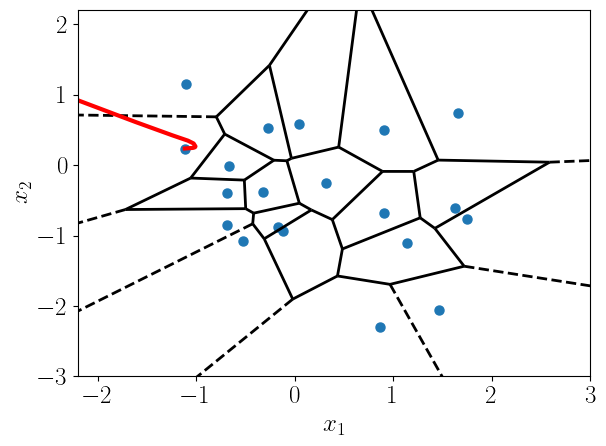

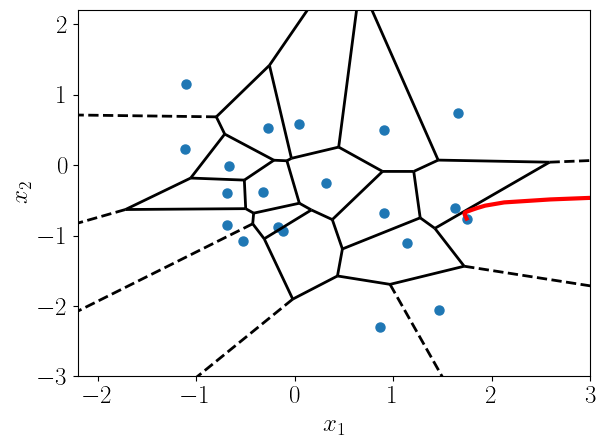

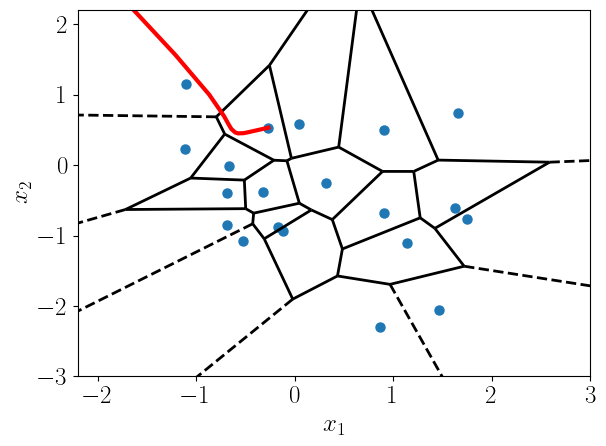

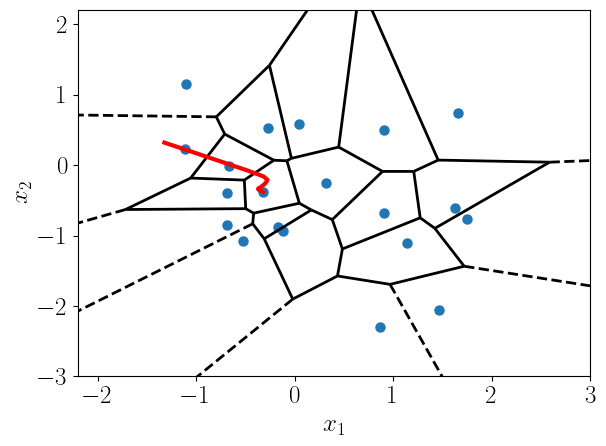

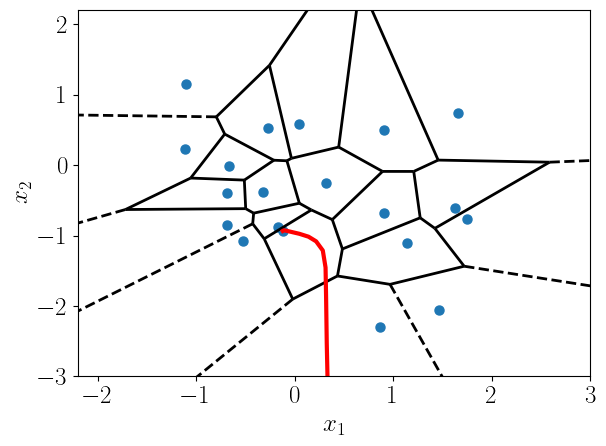

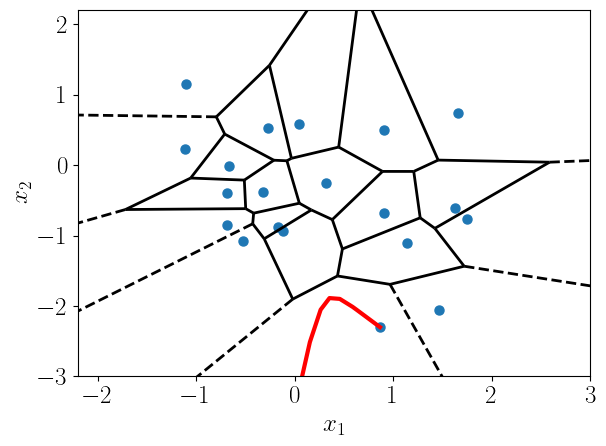

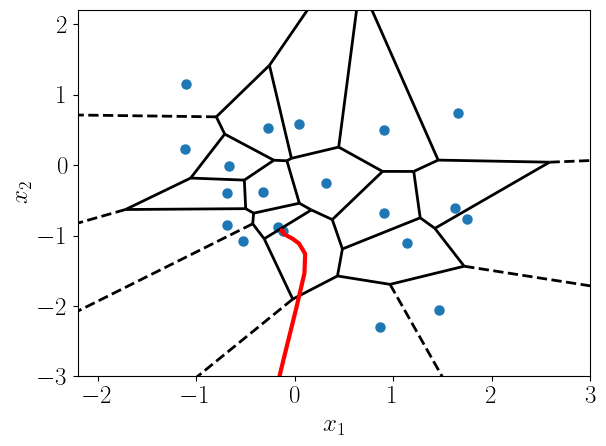

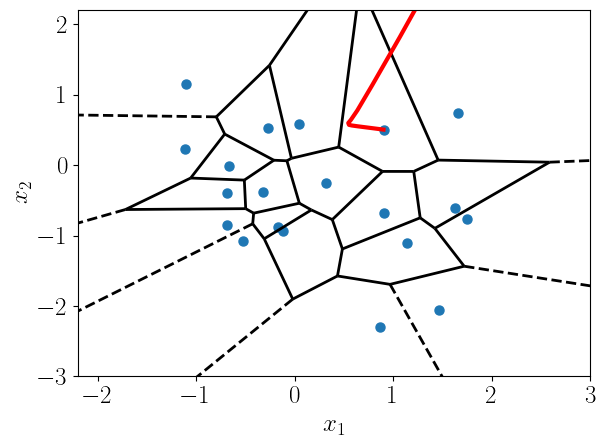

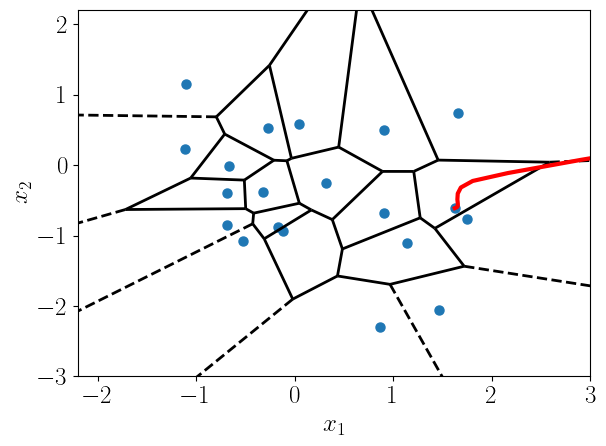

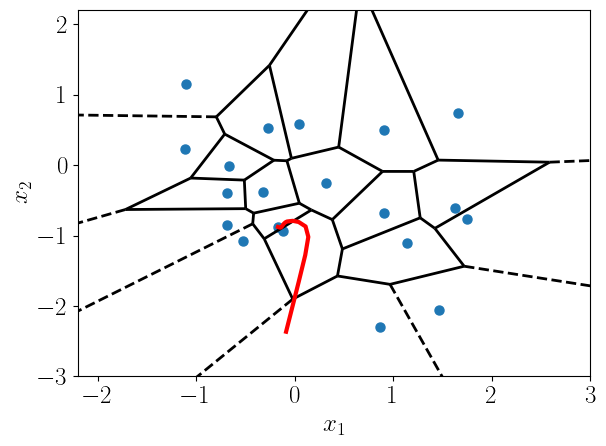

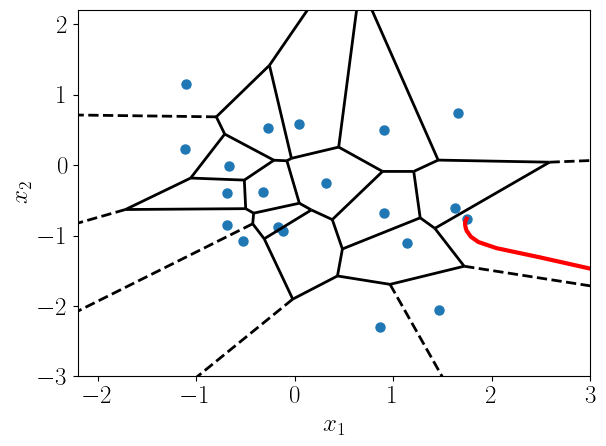

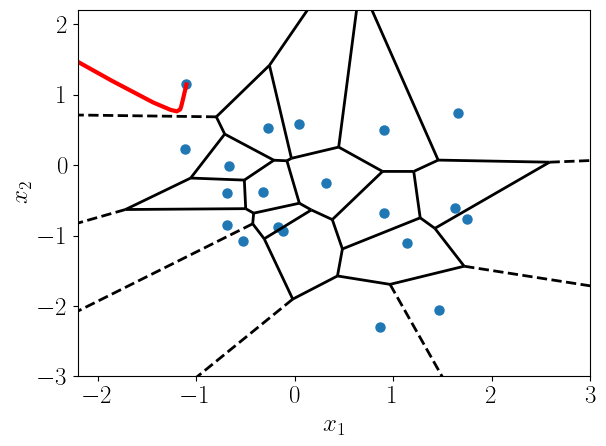

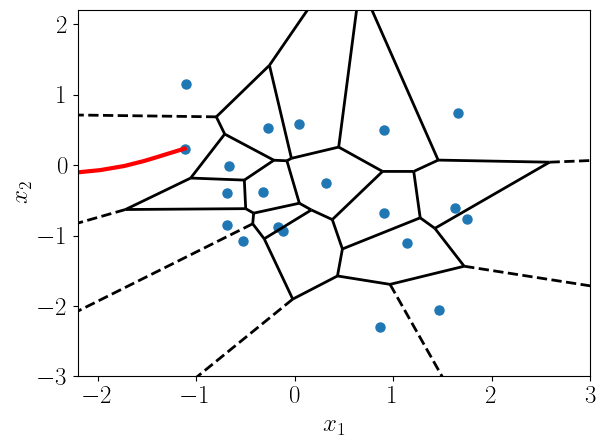

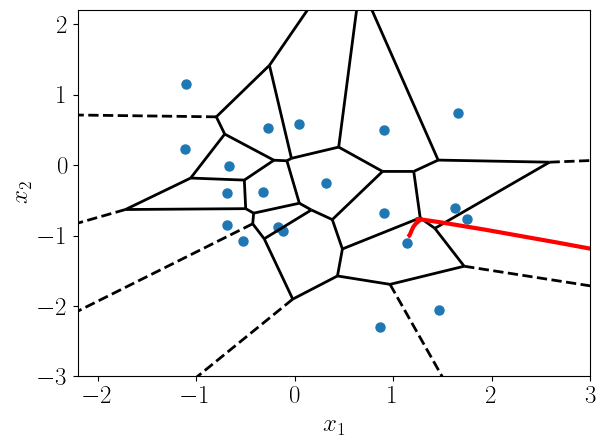

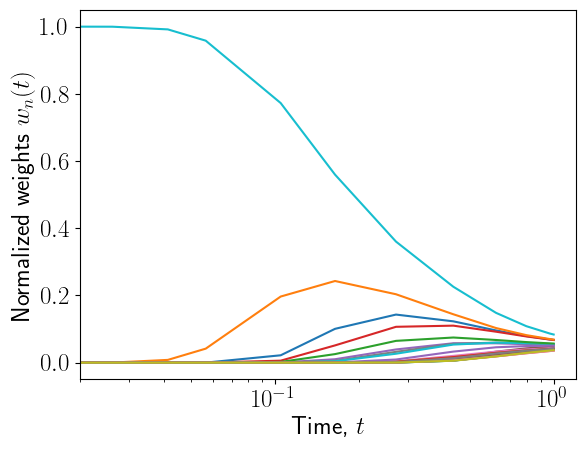

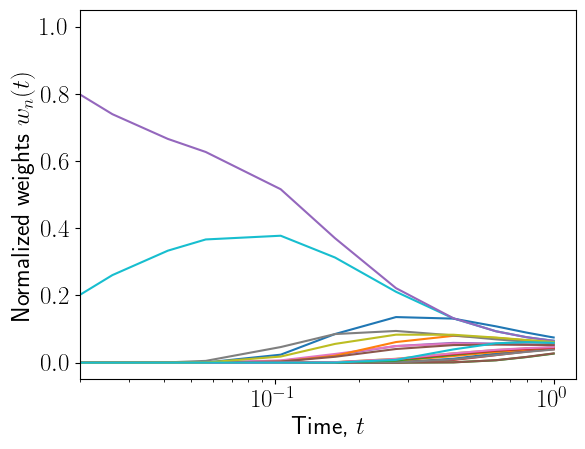

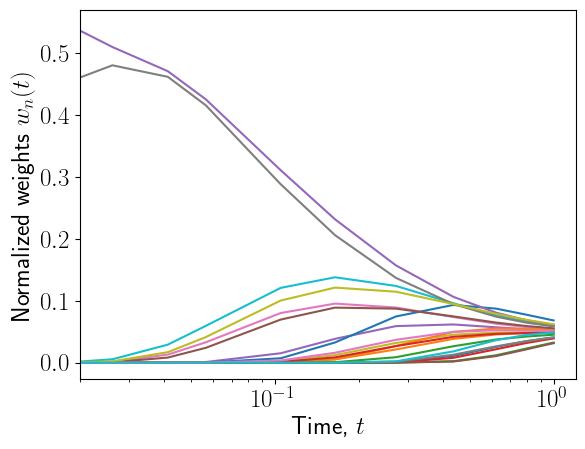

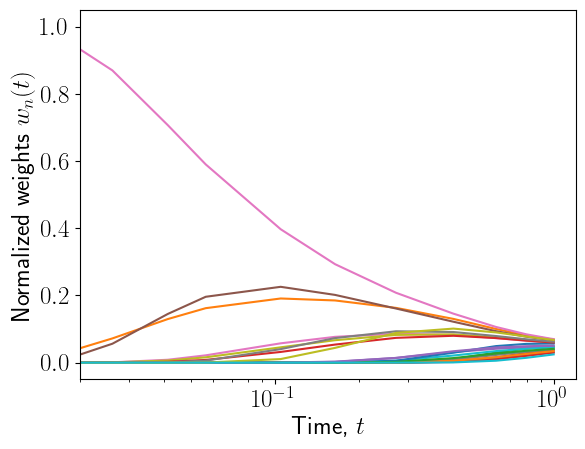

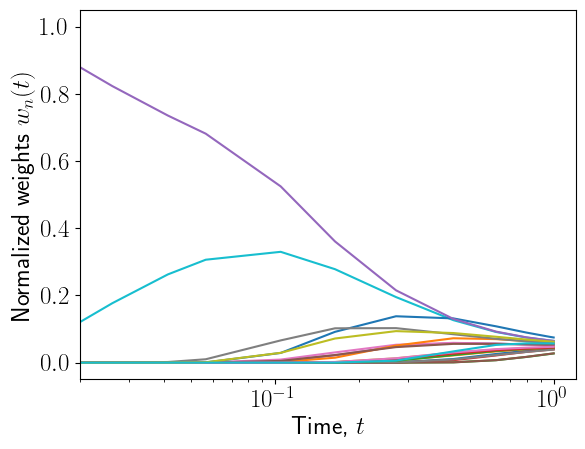

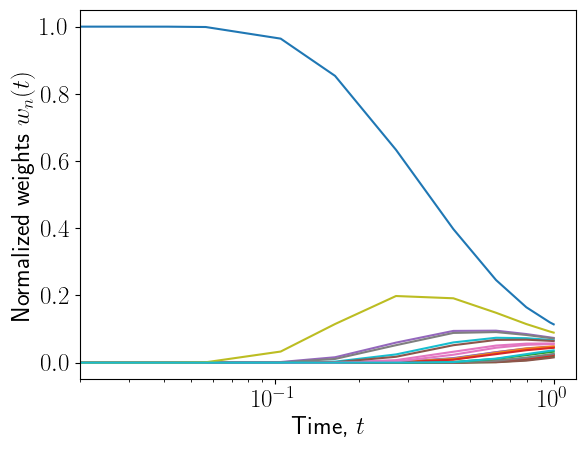

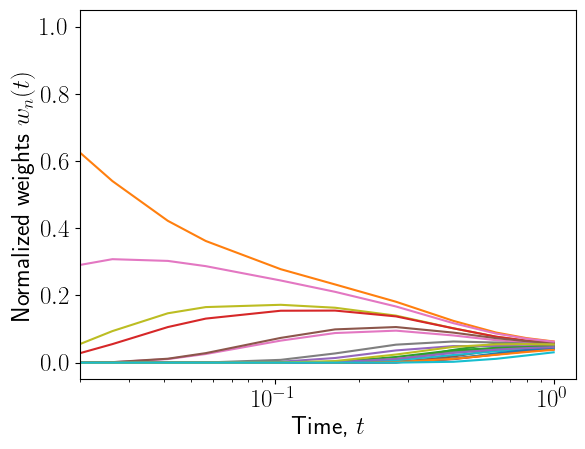

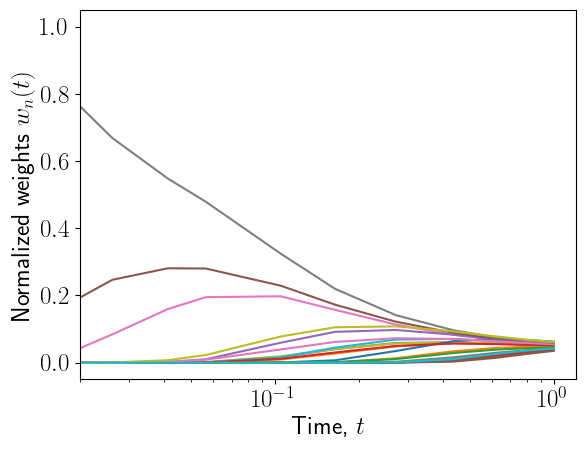

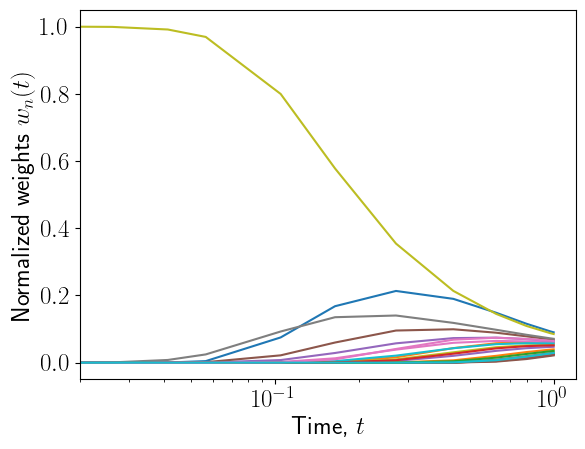

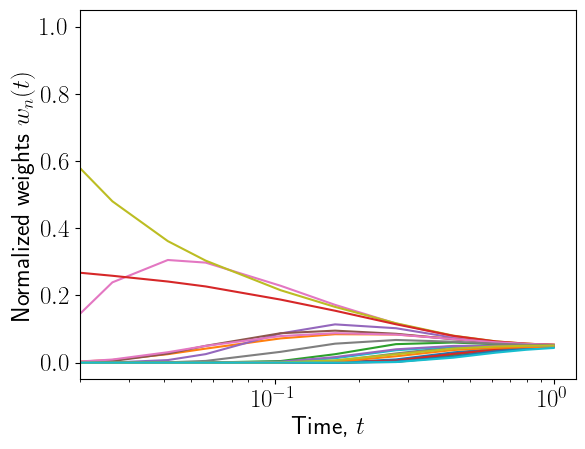

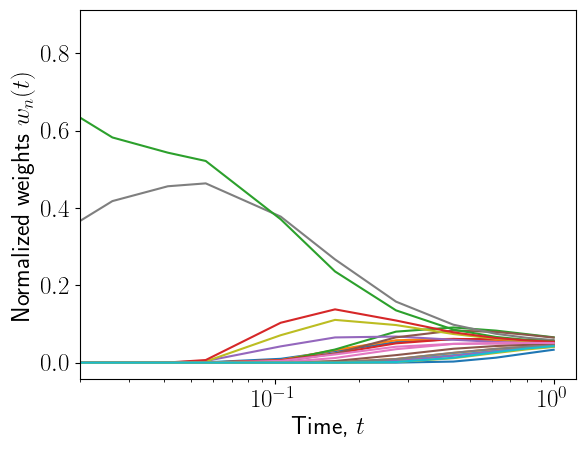

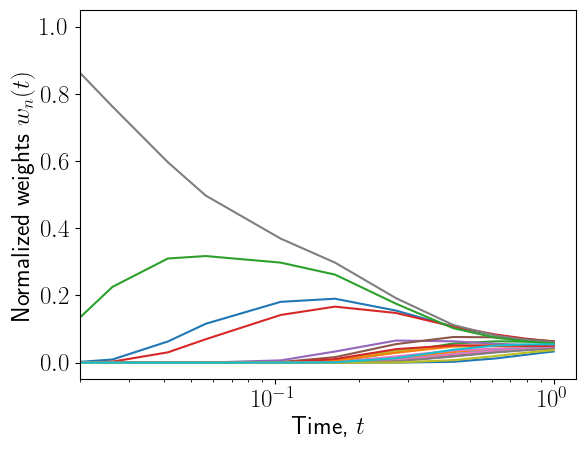

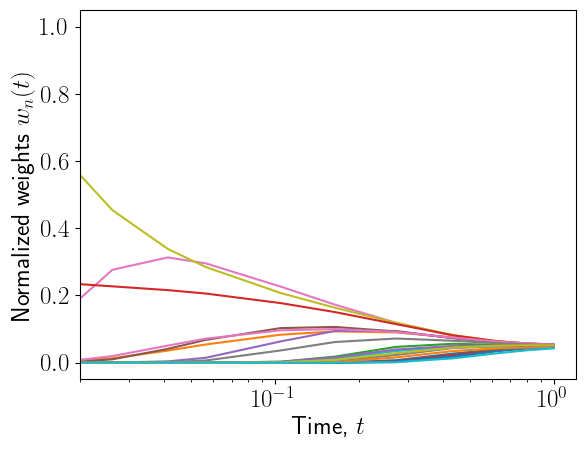

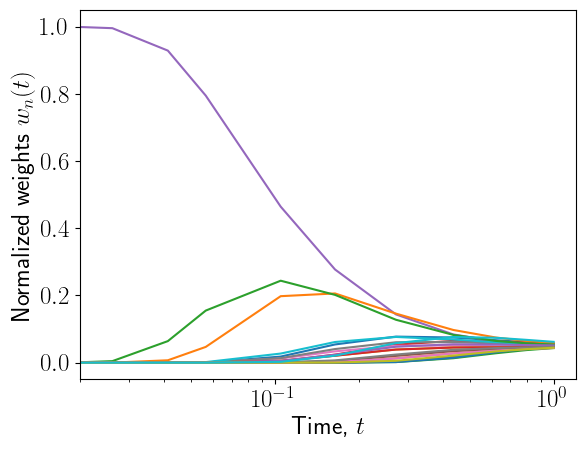

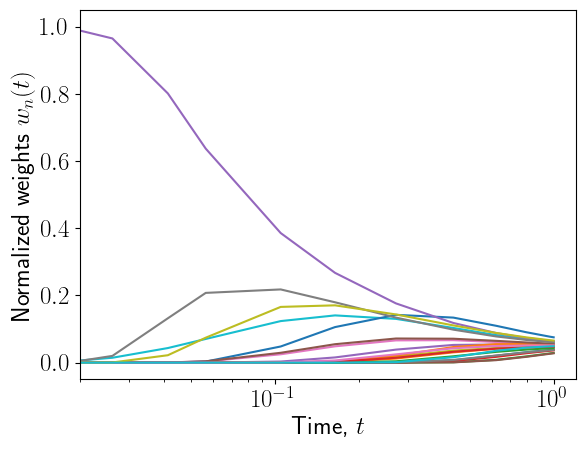

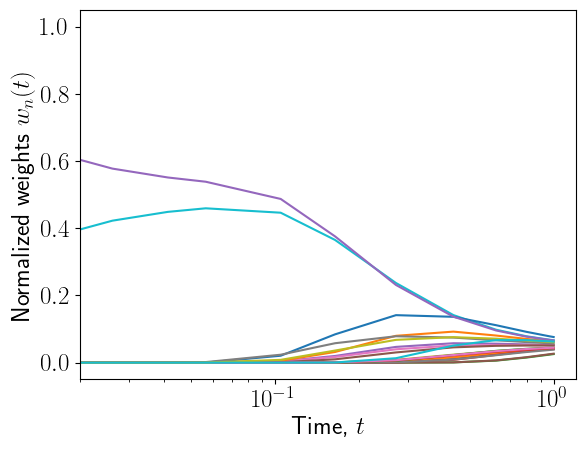

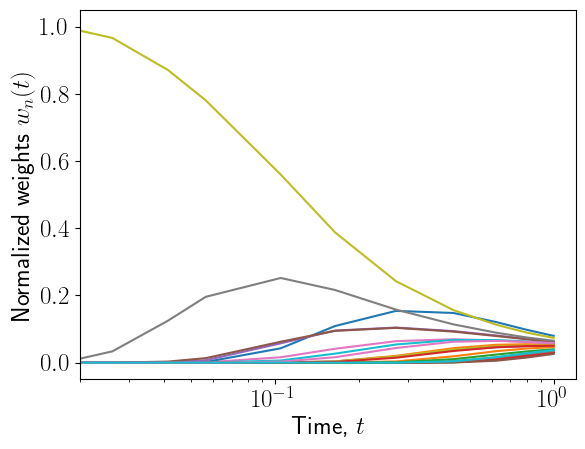

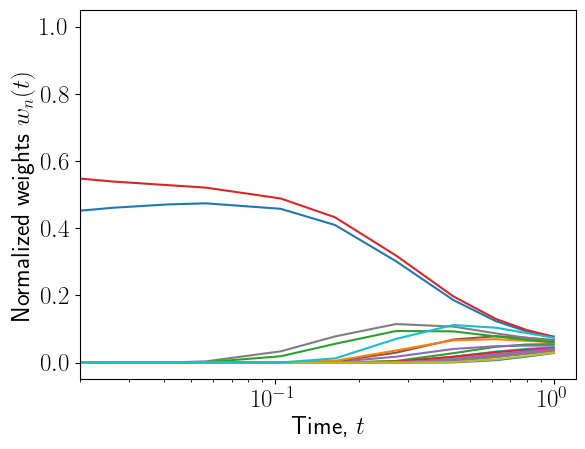

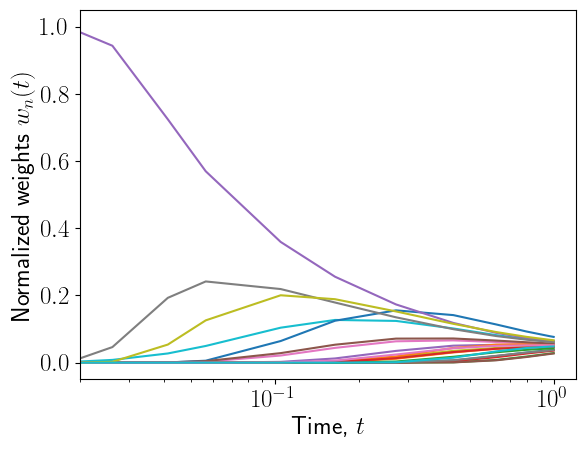

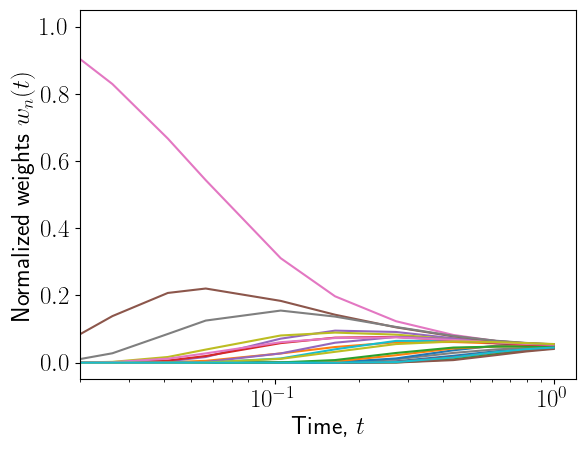

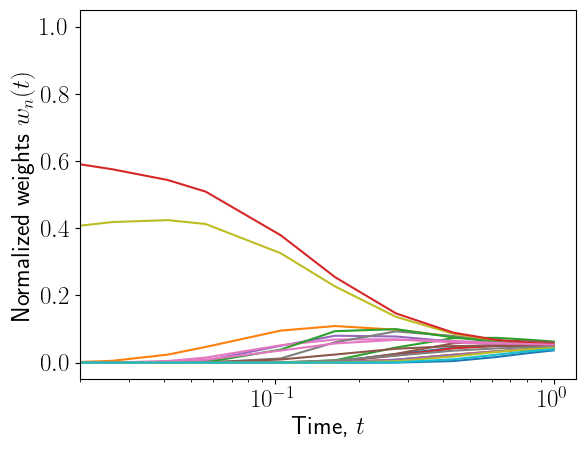

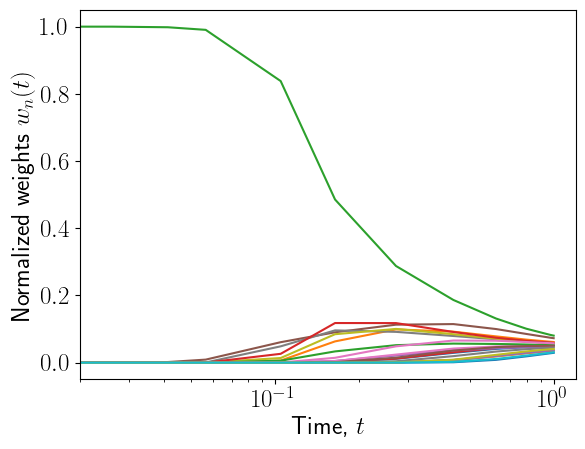

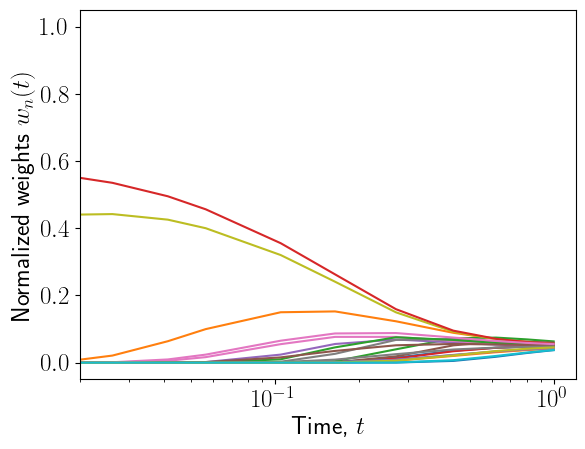

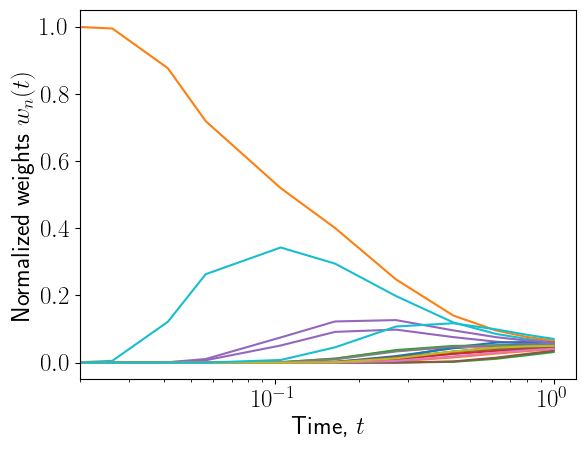

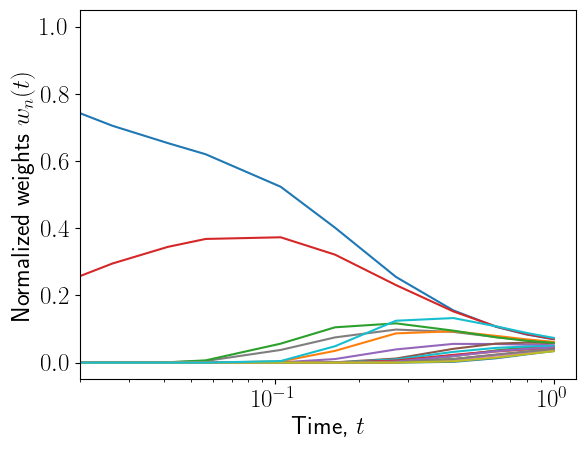

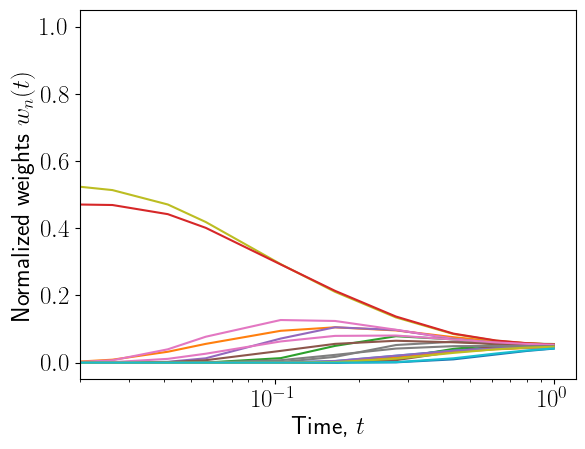

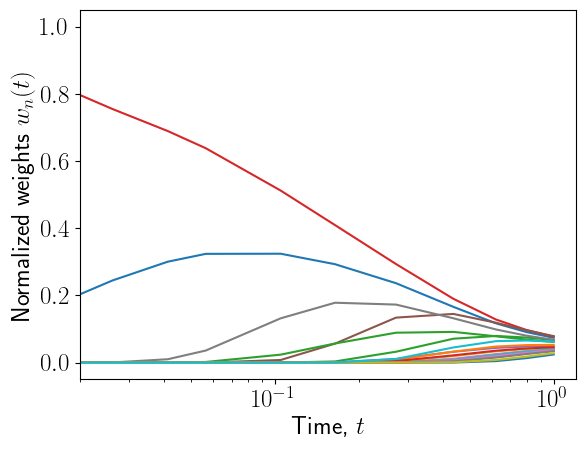

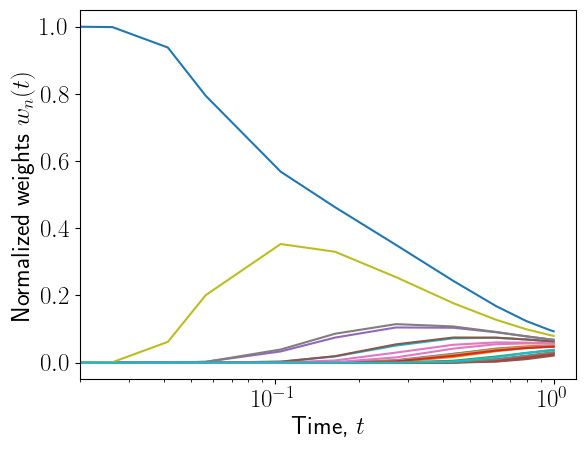

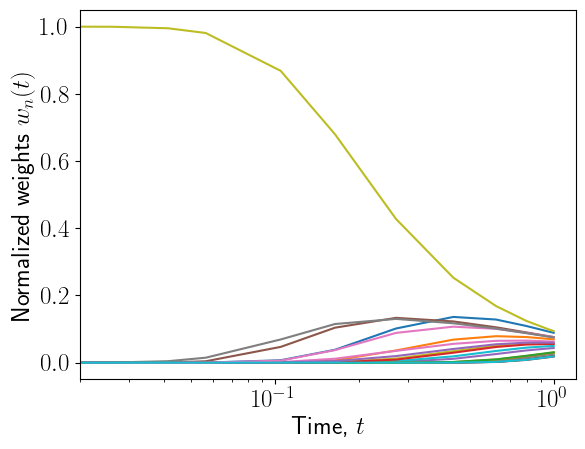

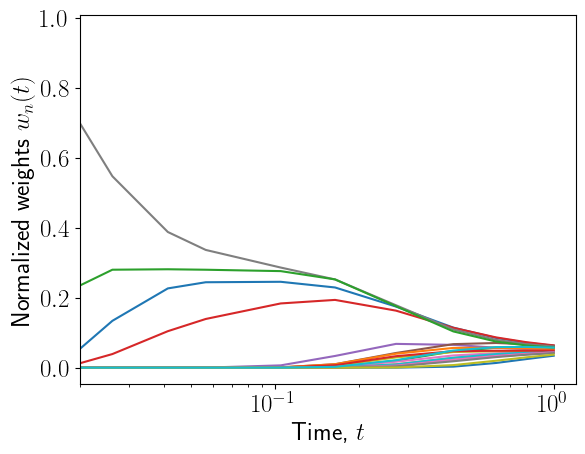

In [5]:
folder = 'figures/VE_EmpiricalBayes'
# create folder to save results if it doesn't exixt
import os
if not os.path.exists(folder):
    os.makedirs(folder)

# plot trajectories
for i in range(batch_size):
    fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, point_size=13)
    plt.plot(GMM_x[i,0,:].detach().numpy(), GMM_x[i,1,:].detach().numpy(), '-r',linewidth=3)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(-2.2,3)
    plt.ylim(-3,2.2)
    plt.tight_layout()
    plt.savefig(folder + '/trajectory_'+str(i)+'.pdf')

# plot weights
for i in range(batch_size):
    plt.figure()
    plt.semilogx(GMM_t, GMMweights[:,i,:])
    plt.xlabel('Time, $t$')
    plt.ylabel('Normalized weights $w_n(t)$')
    plt.xlim(2e-2,1.2)
    plt.savefig(folder + '/weights_'+str(i)+'.pdf')

## Investigate sensitivity to regularization parameter

/Users/ricardobaptista/Documents/Research/ScoreBasedModels/DiffusionModelDynamics/2DGaussianPoints/score_models.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logtau = torch.log(torch.tensor(self.tau_constant))


<Figure size 640x480 with 0 Axes>

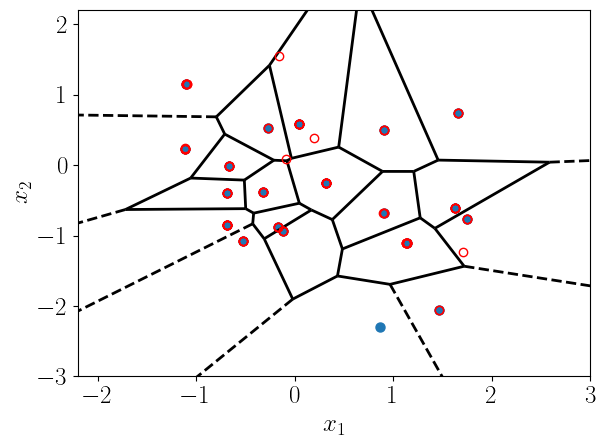

<Figure size 640x480 with 0 Axes>

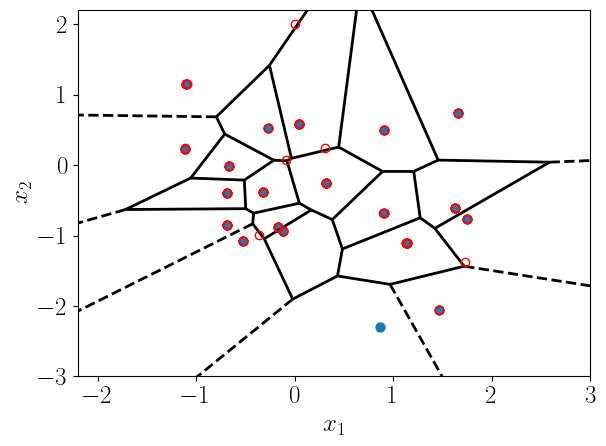

<Figure size 640x480 with 0 Axes>

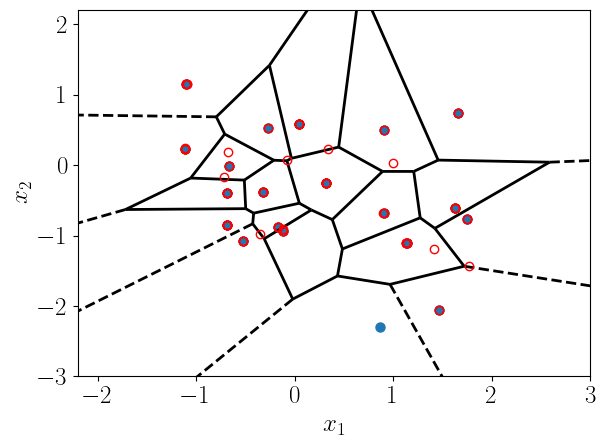

<Figure size 640x480 with 0 Axes>

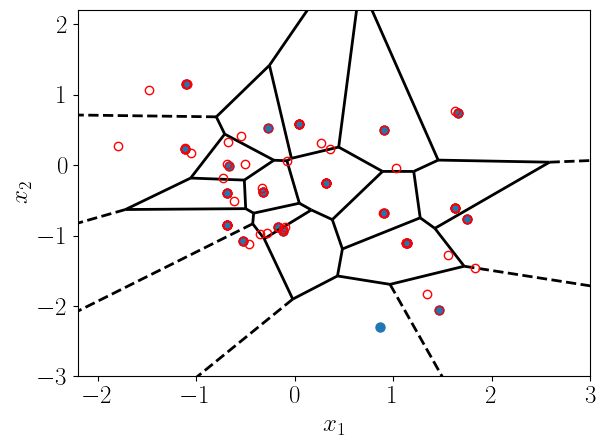

<Figure size 640x480 with 0 Axes>

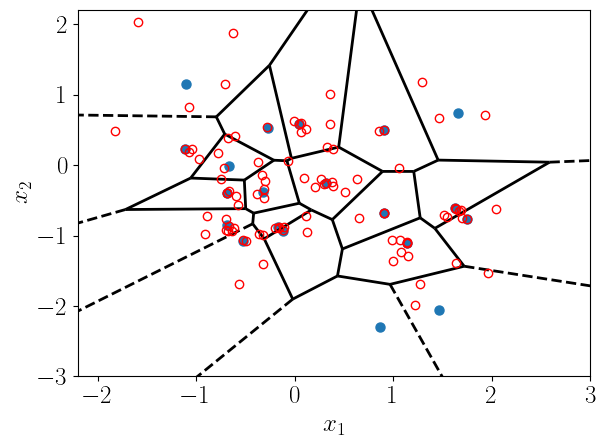

<Figure size 640x480 with 0 Axes>

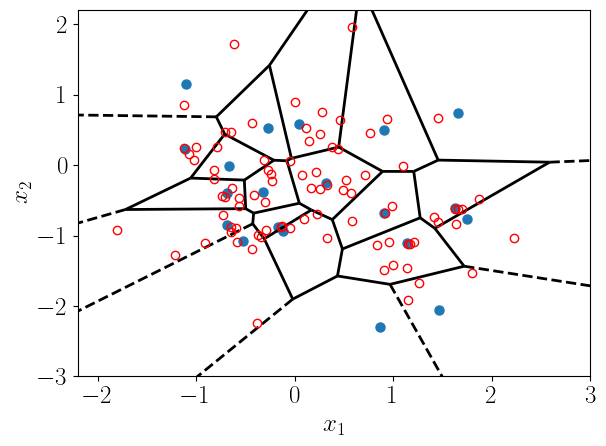

<Figure size 640x480 with 0 Axes>

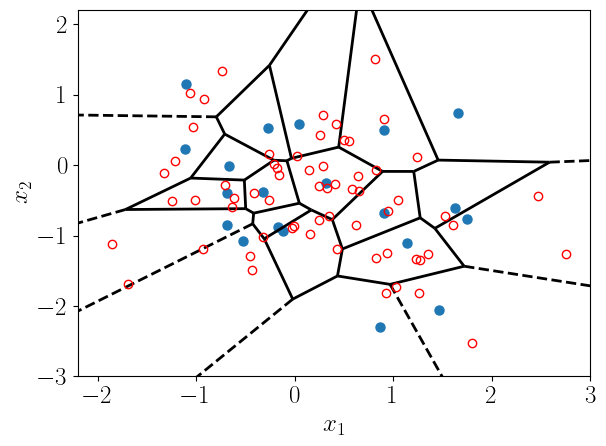

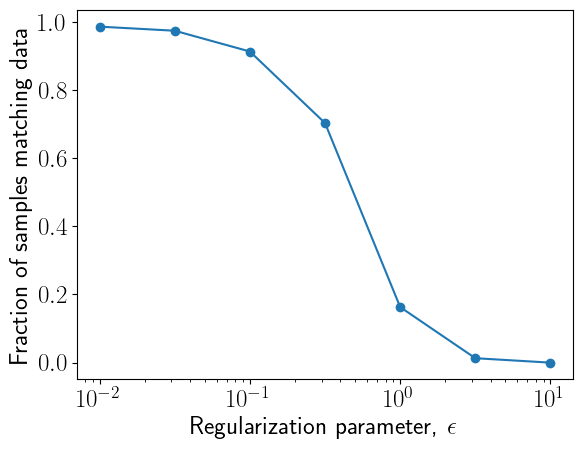

In [ ]:
# define latent samples
batch_size = 1000
latents = torch.randn(batch_size, dim).to(device)

# define regularization parameter constants
tau_vect = torch.logspace(-2,1,7) #[1e-2, 1e-1, 1.0, 10.0]

# define array to store number of collapsed points
count_tau_vect = torch.zeros(len(tau_vect))

# define number of points for plotting
plotting_pts = 100
tolerance = 1e-2

for (kk,tau_constant) in enumerate(tau_vect):

    # define GMM
    gmm_train = GMM_score_EmpiricalBayes(torch.tensor(data, dtype=torch.float32), \
                                         model.marginal_prob_mean, model.marginal_prob_std, tau_constant=tau_constant)

    # evaluate ODE and SDE paths
    GMM_t, GMM_x = model.ODEsampler(gmm_train, latents)
    final_pts = GMM_x[:,:,-1]

    # plot final points (first 100)
    plt.figure()
    fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, point_size=13)
    plt.plot(final_pts[:plotting_pts,0], final_pts[:plotting_pts,1], 'or',mfc='none')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(-2.2,3)
    plt.ylim(-3,2.2)
    plt.tight_layout()
    plt.savefig(folder+'/finalpoints_const_'+str(round(tau_constant.item(),6))+'.pdf')

    # check how close each point is to a data point
    count = 0
    for i in range(batch_size):
        dist = torch.sqrt(torch.sum((final_pts[i,:] - torch.tensor(data, dtype=torch.float32))**2, axis=1))
        if torch.min(dist) < tolerance:
            count += 1
    count_tau_vect[kk] = count/batch_size

# Plot the fraction of points collapsing to data
plt.figure()
plt.semilogx(tau_vect, count_tau_vect, '-o')
plt.xlabel(r'Regularization parameter, $c$')
plt.ylabel(r'Fraction of samples matching data')
plt.tight_layout()
plt.savefig(folder+'/eps_effect.pdf')